## Ideally we should just show them how to use neural network for 1 classification task, and 1 regression task, then we will ask them to change size of the network (number of neurons and number of layers).


# Vanilla Neural Net

In these exercises, we will write a vanilla neural network to distinguish between kick and snare drum samples that we have in the data folder. First, we will write these for 

In [43]:
#import numpy
import numpy as np

#import librosa and display the library verion installed in yoru system
import librosa, librosa.display
print(librosa.__version__)

#import matplotlib 
import matplotlib.pyplot as plt

# Render plots interactively in the notebook (not a must)
#alternatively use matplotlib inline or matplotlib notebook or matplotlib nbagg
%matplotlib inline

#select a different color-scheme for the plots
import matplotlib.style as ms
ms.use('seaborn-muted')

#importing audio widget from IPython.display for audio playback
from IPython.display import Audio

#import scipy or scientific python
import scipy

#import os (helps retrieve the file names from the directory structure on your computer, and much more)
import os

import IPython.display as ipd

#iimport scikit-learn
import sklearn

#importing pandas for being able to load data from files such as comma separated values files
import pandas as pd

#import pathlib to easily write a function to work on all the files in a folder
from pathlib import Path

#importing scikit learn library for learning
import sklearn

0.6.2


#### Exercise 1
For this exercise, we will be training a multi layer perceptron to classify snare and kick drum samples from the Data/drum_samples files.

Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function by training on a dataset, where is the number of dimensions for input and is the number of dimensions for output. Given a set of features and a target, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. Figure 1 shows a one hidden layer MLP with scalar output.
../_images/multilayerperceptron_network.png

Figure 1 : One hidden layer MLP.

The leftmost layer, known as the input layer, consists of a set of neurons
representing the input features. Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation , followed by a non-linear activation function

- like the hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

The module contains the public attributes coefs_ and intercepts_. coefs_ is a list of weight matrices, where weight matrix at index
represents the weights between layer and layer . intercepts_ is a list of bias vectors, where the vector at index represents the bias values added to layer

<img src="https://scikit-learn.org/stable/_images/multilayerperceptron_network.png">

The advantages of Multi-layer Perceptron are:

        Capability to learn non-linear models.
        Capability to learn models in real-time (on-line learning) using partial_fit.

The disadvantages of Multi-layer Perceptron (MLP) include:

        MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy.
        MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.
        MLP is sensitive to feature scaling.



In [12]:
from sklearn.linear_model import Perceptron

## Creating the dataset
First, we need to have a dataset that we can train our model on.

In [13]:
from pathlib import Path

In [14]:
#Extracting features from the training set into different arrays
kick_signals = [
    librosa.load(p)[0] for p in Path().glob('Data/drum_samples/train/kick_*.mp3')
]
snare_signals = [
    librosa.load(p)[0] for p in Path().glob('Data/drum_samples/train/snare_*.mp3')
]

## Constructing a feature vector

In [17]:
def extract_features(signal):
#This is the function definition
    return [
        librosa.feature.zero_crossing_rate(signal)[0, 0],
        librosa.feature.spectral_centroid(signal)[0, 0],
    ]

In [18]:
#Using the above function, we wish to extract features for 
#kick_signals and snare_signals separately

kick_features = np.array([extract_features(x) for x in kick_signals])
snare_features = np.array([extract_features(x) for x in snare_signals])

Let us look at what these features look like. We will initialize a plot and then plot histograms for each of the features.

Text(0, 0.5, 'Count')

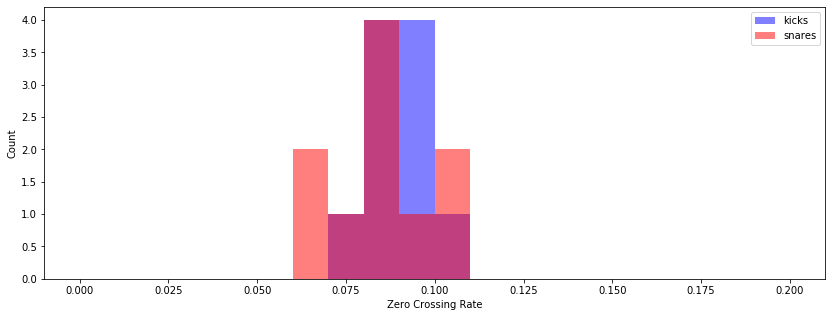

In [39]:
f,ax = plt.subplots(figsize=(14, 5))
plt.hist(kick_features[:,0], color='b', range=(0, 0.2), alpha=0.5, bins=20)
plt.hist(snare_features[:,0], color='r', range=(0, 0.2), alpha=0.5, bins=20)
plt.legend(('kicks', 'snares'))
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

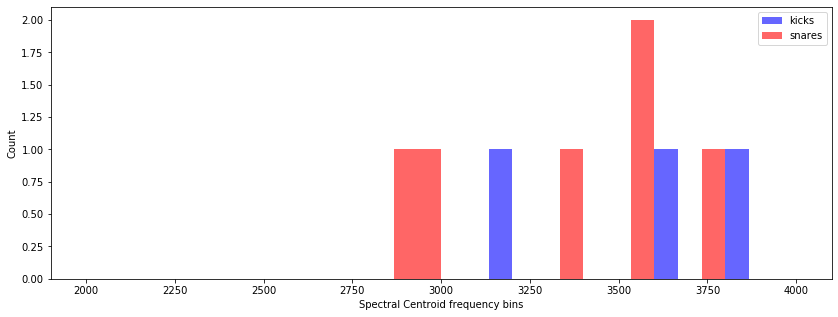

In [40]:
f,ax = plt.subplots(figsize=(14, 5))
plt.hist(kick_features[:,1], color='b', range=(2000, 4000), alpha=0.6, bins=30)
plt.hist(snare_features[:,1], color='r', range=(2000, 4000), alpha=0.6, bins=30)
plt.legend(('kicks', 'snares'))
plt.xlabel('Spectral Centroid frequency bins')
plt.ylabel('Count')

In [23]:
kick_features.shape

(10, 2)

In [24]:
snare_features.shape

(10, 2)

In [25]:
feature_table = np.vstack((kick_features, snare_features))
#we stack the features for both the snares and kicks vertically, so we get 
#a single array containing all the files in the training set, with both features
print(feature_table.shape)

(20, 2)


In [26]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
#We have to scale and normalize the features so that they can be comparable
training_features = scaler.fit_transform(feature_table)

In [27]:
#The first ten data points are kicks, and the last ten data points are snares, 
#so we order a label set containing kicks and snares so the network can learn
labels = np.zeros(20)
for i in range(10):
    labels[i]= 1
labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

## Run an MLP Classifier

In [29]:
from sklearn.neural_network import MLPClassifier
X = training_features
y = labels
clf = MLPClassifier(activation='tanh', solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X, y)     

MLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

# How to stop a network?
Changing layers, different structures of network
Learning rate


# Exercise 1:
### Experiment with learning rate
<br> Figure out how changing the learning rate in the parameters of the MLPCLassifier will change how the network performs.

### Stop condition
<br> Currently, the network stops when it has completed a maximum number of iterations. What other learning strategies could be used?

In [36]:
# Write your code here

## Create Test Feature Set

### Extracting features from the training set into different arrays

In [37]:
from pathlib import Path
#Load test signals
test_signals = [
    librosa.load(p)[0] for p in Path().glob('Data/drum_samples/test/*.mp3')
]

In [38]:
#Calculate test features
test_features = np.array([extract_features(x) for x in test_signals])

scaler_test = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
#We have to scale and normalize the features so that they can be comparable
testing_features = scaler.fit_transform(test_features)

In [39]:
clf.predict = testing_features[1]
print(clf.predict)

[-0.05263158 -0.07300686]


In [40]:
from sklearn import svm
from sklearn.model_selection import train_test_split

random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Limit to the two first classes, and split into training and test
X_train, X_test, y_train, y_test = train_test_split(X[y < 2], y[y < 2],
                                                    test_size=.5,
                                                    random_state=random_state)

# Create a simple classifier
classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

In [41]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.60


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.60')

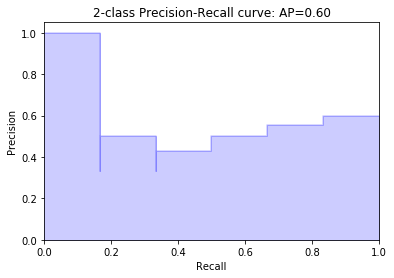

In [42]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

## Change the features that we choose